In [1]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(ggrepel))

barcode_reads_cutoff <- 10
insert_reads_cutoff <- 300
barcodes_cutoff <- 4

In [2]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [3]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Plot CSCs of dicodon library vs endogenous fragments library in WT


In [4]:
insert_annotations_1 = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    mutate(aa = as.character(translate(DNAStringSet(insert), no.init.codon = T)))

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
barcode_counts_e51 <- read_tsv("../../wt_mrna_grna/tables/barcode_insert_counts.tsv.gz")

Rows: 370377 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): barcode, sample_name, linkage_ref
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
insert_annotations_codon_freq <- read_csv("../annotations/insert_annotations_codon_frequencies.csv") %>%
    select(-`...1`) %>%
    mutate(insert_num = as.character(insert_num)) %>%
    mutate_if(is.numeric, funs(./16)) %>%
    mutate(insert_num = as.numeric(insert_num))

head(insert_annotations_codon_freq)

New names:
• `` -> `...1`
Rows: 6000 Columns: 67
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): insert
dbl (66): ...1, insert_num, AAA, AAC, AAG, AAT, ACA, ACC, ACG, ACT, AGA, AGC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


insert_num,insert,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,⋯,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,1.0,0.0,0.0,0.0,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,AAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAAC,0.5,0.5,0.0,0.0,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,AAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAG,0.5,0.0,0.5,0.0,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AAAAATAAAAATAAAAATAAAAATAAAAATAAAAATAAAAATAAAAAT,0.5,0.0,0.0,0.5,0.0,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACA,0.5,0.0,0.0,0.0,0.5,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACC,0.5,0.0,0.0,0.0,0.0,0.5,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
inserts_lfc <- barcode_counts_e51 %>%
    group_by(sample_name, insert_num) %>%
    summarize(count = sum(barcode_count), n_barcodes = n(), .groups='drop') %>%
    filter(n_barcodes >= barcodes_cutoff) %>%
    filter(count >= insert_reads_cutoff) %>%
    pivot_wider(names_from = sample_name, values_from = c(count, n_barcodes)) %>%
    mutate(lfc = log2(count_wt_mrna) - log2(count_wt_gdna)) %>%
    drop_na(lfc) %>%
    left_join(insert_annotations_codon_freq, by='insert_num') %>%
    mutate(type = ifelse(insert_num >=4095, 'endo', 'dicodon')) %>%
    group_by(type) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    ungroup()

head(inserts_lfc)

insert_num,count_wt_gdna,count_wt_mrna,n_barcodes_wt_gdna,n_barcodes_wt_mrna,lfc,insert,AAA,AAC,AAG,⋯,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,type,lfc_med
<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,8382,2640,24,21,-1.666757,AAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAAC,0.5,0.5,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.13184210
2,2630,469,18,16,-2.487403,AAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAGAAAAAG,0.5,0.0,0.5,⋯,0,0,0,0,0,0,0,0,dicodon,-0.95248848
4,7186,2248,22,20,-1.676547,AAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACAAAAACA,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.14163241
5,23361,9241,72,68,-1.337981,AAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACCAAAACC,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.19693334
6,18582,5596,51,44,-1.731438,AAAACGAAAACGAAAACGAAAACGAAAACGAAAACGAAAACGAAAACG,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.19652343
7,4766,1699,16,15,-1.488093,AAAACTAAAACTAAAACTAAAACTAAAACTAAAACTAAAACTAAAACT,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.04682139


Warning message:
“Ignoring unknown parameters: linewidth”


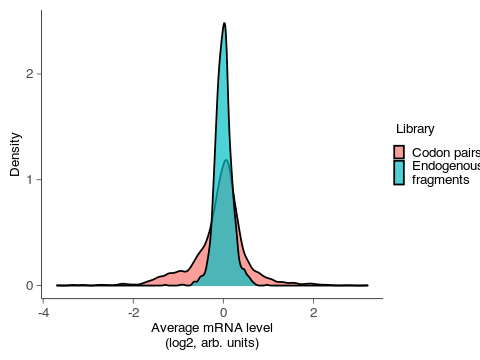

In [8]:
inserts_lfc %>%
    select(type, lfc_med) %>%
    mutate(type = case_when(type == 'dicodon' ~ 'Codon pairs', type == 'endo' ~ 'Endogenous\nfragments', type == 'endo_motifs' ~ 'Endogenous motifs')) %>%
    ggplot() +
    aes(x=lfc_med, fill=type) +
    geom_density(alpha=0.7, linewidth=0.2) +
    scale_y_continuous(breaks=seq(0,3,1)) +
    theme +
    theme(legend.box.margin=margin(-12,-12,-12,-12),) +
    guides(fill = guide_legend(
                 keywidth=0.1,
                 keyheight=0.125,
                 default.unit="inch",
                 linewidth=0.2)) +
    labs(y='Density', x='Average mRNA level\n(log2, arb. units)', fill='Library')

ggsave("../figures/dist_dicodon_vs_endo_fragments.pdf", width=3, height=1.7)

In [9]:
endo_insert_lfc <- inserts_lfc %>%
    filter(insert_num > 4095)
dicodon_insert_lfc <- inserts_lfc %>%
    filter(insert_num <= 4095)

In [10]:
endo_csc <- lapply(endo_insert_lfc[8:71], function(x) {
    cor(x, endo_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”


In [11]:
dicodon_csc <- lapply(dicodon_insert_lfc[8:71], function(x) {
    cor(x, dicodon_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

In [12]:
dicodon_endo_csc <- dicodon_csc %>%
    rename(dicodon_csc = corr_freq_lfc) %>%
    inner_join(endo_csc, by='codon') %>%
    rename(endo_csc = corr_freq_lfc) %>%
    drop_na()

In [13]:
wt_endo_dicodon_csc <- dicodon_endo_csc %>%
    mutate(genotype = 'wt')

Warning message:
“Ignoring unknown parameters: linewidth”
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



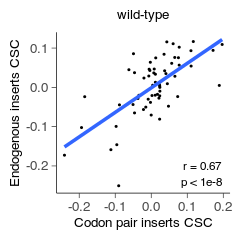

In [14]:
options(repr.plot.width = 2, repr.plot.height = 2)

pearson_r = cor(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))
pearson_p = cor.test(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))$p.value

dicodon_endo_csc %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>%
    ggplot() +
    aes(x=dicodon_csc, y=endo_csc) +
    geom_point(size=0.2) +
    geom_smooth(method=lm, se=FALSE, linewidth=0.2) +
    annotate('text', x = 0.140, y = -0.20, label = str_c("r = ", round(pearson_r, 2)),  size=7/.pt) +
    annotate('text', x = 0.140, y = -0.24, label = "p < 1e-8", size=7/.pt) +
    theme +
    theme(
        plot.title = element_text(hjust = 0.5, size=8)
    ) + 
    labs(x='Codon pair inserts CSC', y='Endogenous inserts CSC', title='wild-type')

ggsave("../figures/endo_vs_dicodon_codon_analogous_csc.pdf", width=2, height=1.95, units='in', dpi=300)

In [15]:
pearson_p

[1] 3.656327e-09

## Plot CSCs of dicodon library vs endogenous fragments library in hel2-del


In [16]:
barcode_counts_e67 <- read_tsv("../../hel2_syh1_mrna_grna/tables/barcode_insert_counts.tsv.gz")

Rows: 673897 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genotype, sample_type
dbl (3): barcode_num, insert_num, barcode_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
inserts_lfc_hel2 <- barcode_counts_e67 %>%
    filter(genotype == 'hel2') %>%
    group_by(genotype, sample_type, insert_num) %>%
    summarize(count = sum(barcode_count), n_barcodes = n(), .groups='drop') %>%
    filter(n_barcodes >= barcodes_cutoff) %>%
    filter(count >= insert_reads_cutoff) %>%
    pivot_wider(names_from = c(sample_type), values_from = c(count, n_barcodes)) %>%
    mutate(lfc = log2(count_mrna) - log2(count_gdna)) %>%
    drop_na(lfc) %>%
    left_join(insert_annotations_codon_freq, by='insert_num') %>%
    mutate(type = ifelse(insert_num >=4095, 'endo', 'dicodon')) %>%
    group_by(type) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    select(-insert) %>%
    ungroup()

head(inserts_lfc_hel2)

genotype,insert_num,count_gdna,count_mrna,n_barcodes_gdna,n_barcodes_mrna,lfc,AAA,AAC,AAG,⋯,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,type,lfc_med
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
hel2,1,7141,8225,27,31,0.20388956,0.5,0.5,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,1.564592e-01
hel2,2,7567,12250,22,24,0.69498840,0.5,0.0,0.5,⋯,0,0,0,0,0,0,0,0,dicodon,6.475581e-01
hel2,4,8960,9259,25,25,0.04735765,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-7.268978e-05
hel2,5,25440,39600,62,59,0.63840176,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,5.909714e-01
hel2,6,21431,19452,43,40,-0.13978067,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-1.872110e-01
hel2,7,13769,11807,14,14,-0.22178134,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-2.692117e-01


In [18]:
endo_insert_lfc <- inserts_lfc_hel2 %>%
    filter(insert_num > 4095)
dicodon_insert_lfc <- inserts_lfc_hel2 %>%
    filter(insert_num <= 4095)

In [19]:
endo_csc <- lapply(endo_insert_lfc[8:71], function(x) {
    cor(x, endo_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”


In [20]:
dicodon_csc <- lapply(dicodon_insert_lfc[8:71], function(x) {
    cor(x, dicodon_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

In [21]:
dicodon_endo_csc <- dicodon_csc %>%
    rename(dicodon_csc = corr_freq_lfc) %>%
    inner_join(endo_csc, by='codon') %>%
    rename(endo_csc = corr_freq_lfc) %>%
    drop_na()

In [22]:
hel2_endo_dicodon_csc <- dicodon_endo_csc %>%
    mutate(genotype = 'hel2')

Warning message:
“Ignoring unknown parameters: linewidth”


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



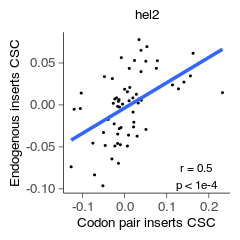

In [23]:
options(repr.plot.width = 2, repr.plot.height = 2)

pearson_r = cor(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))
pearson_p = cor.test(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))$p.value

dicodon_endo_csc %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>%
    ggplot() +
    aes(x=dicodon_csc, y=endo_csc) +
    geom_point(size=0.2) +
    geom_smooth(method=lm, se=FALSE, linewidth=0.2) +
    annotate('text', x = 0.17, y = -0.075, label = str_c("r = ", round(pearson_r, 2)),  size=7/.pt) +
    annotate('text', x = 0.17, y = -0.095, label = "p < 1e-4", size=7/.pt) +
    theme +
    theme(
        plot.title = element_text(hjust = 0.5, size=8)
        ) + 
    labs(x='Codon pair inserts CSC', y='Endogenous inserts CSC', title='hel2')

ggsave("../figures/hel2_endo_vs_dicodon_codon_analogous_csc.pdf", width=2.06, height=1.95, units='in', dpi=300)

In [24]:
pearson_p

[1] 4.479249e-05

## Plot CSC dicodon vs endogenous for Syh1

In [25]:
inserts_lfc_syh1 <- barcode_counts_e67 %>%
    filter(genotype == 'syh1') %>%
    group_by(genotype, sample_type, insert_num) %>%
    summarize(count = sum(barcode_count), n_barcodes = n(), .groups='drop') %>%
    filter(n_barcodes >= barcodes_cutoff) %>%
    filter(count >= insert_reads_cutoff) %>%
    pivot_wider(names_from = c(sample_type), values_from = c(count, n_barcodes)) %>%
    mutate(lfc = log2(count_mrna) - log2(count_gdna)) %>%
    drop_na(lfc) %>%
    left_join(insert_annotations_codon_freq, by='insert_num') %>%
    mutate(type = ifelse(insert_num >=4095, 'endo', 'dicodon')) %>%
    group_by(type) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    select(-insert) %>%
    ungroup()

head(inserts_lfc_syh1)

genotype,insert_num,count_gdna,count_mrna,n_barcodes_gdna,n_barcodes_mrna,lfc,AAA,AAC,AAG,⋯,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,type,lfc_med
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
syh1,1,3095,10708,28,28,1.790678,0.5,0.5,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.1279837
syh1,2,2350,6921,28,29,1.558320,0.5,0.0,0.5,⋯,0,0,0,0,0,0,0,0,dicodon,-0.1043743
syh1,4,3325,11318,24,26,1.767193,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.1044988
syh1,5,5273,20131,60,62,1.932723,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,0.2700289
syh1,6,4645,11636,44,51,1.324845,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.3378493
syh1,7,1653,4837,15,16,1.549026,0.5,0.0,0.0,⋯,0,0,0,0,0,0,0,0,dicodon,-0.1136682


In [26]:
endo_insert_lfc <- inserts_lfc_syh1 %>%
    filter(insert_num > 4095)
dicodon_insert_lfc <- inserts_lfc_syh1 %>%
    filter(insert_num <= 4095)

In [27]:
endo_csc <- lapply(endo_insert_lfc[8:71], function(x) {
    cor(x, endo_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”
Warning message in cor(x, endo_insert_lfc$lfc_med, method = "pearson"):
“the standard deviation is zero”


In [28]:
dicodon_csc <- lapply(dicodon_insert_lfc[8:71], function(x) {
    cor(x, dicodon_insert_lfc$lfc_med, method='pearson')
}) %>%
    enframe() %>%
    rename(codon = name, corr_freq_lfc=value) %>%
    mutate(corr_freq_lfc = as.numeric(corr_freq_lfc))

In [29]:
dicodon_endo_csc <- dicodon_csc %>%
    rename(dicodon_csc = corr_freq_lfc) %>%
    inner_join(endo_csc, by='codon') %>%
    rename(endo_csc = corr_freq_lfc) %>%
    drop_na()

Warning message:
“Ignoring unknown parameters: linewidth”
`geom_smooth()` using formula 'y ~ x'



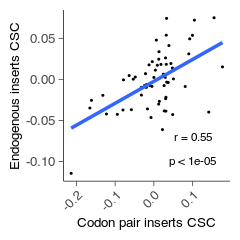

In [30]:
options(repr.plot.width = 2, repr.plot.height = 2)

pearson_r = cor(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))
pearson_p = cor.test(dicodon_endo_csc$dicodon_csc, dicodon_endo_csc$endo_csc, method=c('pearson'))$p.value

dicodon_endo_csc %>%
    mutate(name = str_c(codon, " (", GENETIC_CODE[codon], ")")) %>%
    ggplot() +
    aes(x=dicodon_csc, y=endo_csc) +
    geom_point(size=0.2) +
    geom_smooth(method=lm, se=FALSE, linewidth=0.2) +
    annotate('text', x = 0.1, y = -0.07, label = str_c("r = ", round(pearson_r, 2)),  size=7/.pt) +
    annotate('text', x = 0.1, y = -0.1, label = "p < 1e-05", size=7/.pt) +
    theme +
    theme(axis.text.x=element_text(angle=45, hjust=1,vjust=1)) + 
    labs(x='Codon pair inserts CSC', y='Endogenous inserts CSC')

# ggsave("../figures/syh1_endo_vs_dicodon_codon_analogous_csc.pdf", width=1.95, height=1.7, units='in', dpi=300)